In [1]:
# ==============================================================================
# --- Import ---
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import math as math


# Import our new, separated modules
from parameters import PortfolioResult, CompanyResult
import engine as vcm
from engine import convert_multiple_simulations_to_excel_with_flows

# This line correctly imports the fully-processed and validated
# parameters from your loader script.
from parameters_loader import fund_params as base_case_params

from analysis_utils import display_portfolio_deep_dive, display_company_journeys

# Configure display and logging
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("✅ Parameters loaded successfully from 'parameters_loader.py'")

✅ Configuration file successfully validated against schema.
✅ Configuration file successfully passed logical validation.
✅ FundParameters object created successfully.
✅ Parameters loaded successfully from 'parameters_loader.py'


In [4]:
##################################################################
# This runs the simulation and captures details in an excel file
##################################################################

from tabnanny import verbose

from numpy import True_
from engine import run_monte_carlo 

N_simulations_to_run = 1000

all_results, all_gross_flows,waterfall_log,net_lp_flows_log = run_monte_carlo(
    params=base_case_params, 
    num_simulations=N_simulations_to_run,
    seed=421,
    verbose= False
)


2025-09-22 08:39:03,669 - INFO - Starting Monte Carlo simulation: 1000 runs with seed=421


Running 1000 fund simulations...
  Progress: 100/1000 (10%) complete
  Progress: 200/1000 (20%) complete
  Progress: 300/1000 (30%) complete
  Progress: 400/1000 (40%) complete
  Progress: 500/1000 (50%) complete
  Progress: 600/1000 (60%) complete
  Progress: 700/1000 (70%) complete
  Progress: 800/1000 (80%) complete
  Progress: 900/1000 (90%) complete


2025-09-22 08:39:26,665 - INFO - Monte Carlo simulation complete: 1000 successful runs


  Progress: 1000/1000 (100%) complete
Monte Carlo simulation complete: 1000 successful runs


In [5]:
# Use the updated function that includes waterfall_log and net_lp_flows_log
df_companies, df_history, df_flows, waterfall_log, net_lp_flows_log = convert_multiple_simulations_to_excel_with_flows(
    all_results, 
    all_gross_flows,
    waterfall_log=waterfall_log,
    net_lp_flows_log=net_lp_flows_log,
    filename="multi_simulation_fund_performance_with_flows_and_waterfall.xlsx"
)

print(f"\n--- Simulation Complete ---")
print(f"  Generated {len(all_results)} portfolio outcomes.")
print(f"  Captured {len(df_flows)} total cash flow events.")
print(f"  Waterfall details: {len(waterfall_log)} records")
print(f"  Net LP flows: {len(net_lp_flows_log)} records")


Processing 500 simulation results for Excel export...
Excel export complete: multi_simulation_fund_performance_with_flows_and_waterfall.xlsx
Summary:
  • Simulations: 500
  • Companies: 15525 total across all simulations
  • Investment events: 28164
  • Cash flows: 26651
  • Waterfall records: 5031
  • Net LP flow records: 7029

--- Simulation Complete ---
  Generated 500 portfolio outcomes.
  Captured 26651 total cash flow events.
  Waterfall details: 5031 records
  Net LP flows: 7029 records



--- MODEL DIAGNOSTICS ---
Percentage of portfolios that became capital constrained: 0.00%
Percentage of Net IRRs floored to -100% (total loss): 0.00%


--- PORTFOLIO PERFORMANCE STATISTICS ---

IRR & Multiple Statistics:


,gross_irr,net_irr,gross_multiple,net_multiple
count,"1,000","1,000","1,000","1,000"
mean,-7.61%,-3.26%,1.25x,1.04x
std,38.99%,15.10%,0.93x,0.64x
min,-100.00%,-49.54%,0.00x,0.10x
5%,-100.00%,-28.89%,0.15x,0.23x
25%,-24.03%,-14.29%,0.57x,0.56x
50%,1.18%,-1.94%,1.04x,0.93x
75%,18.55%,8.02%,1.72x,1.40x
95%,39.22%,19.33%,3.04x,2.18x
max,123.08%,33.66%,6.39x,4.39x



Key Risk Metrics (Based on Net IRR):
  Value at Risk (VaR) at 5%: -28.89% (The worst-case outcome in 95% of scenarios)
  Conditional VaR (CVaR) at 5%: -34.99% (The average outcome of the worst 5% of scenarios)


--- VISUALIZATION: NET IRR DISTRIBUTION ---


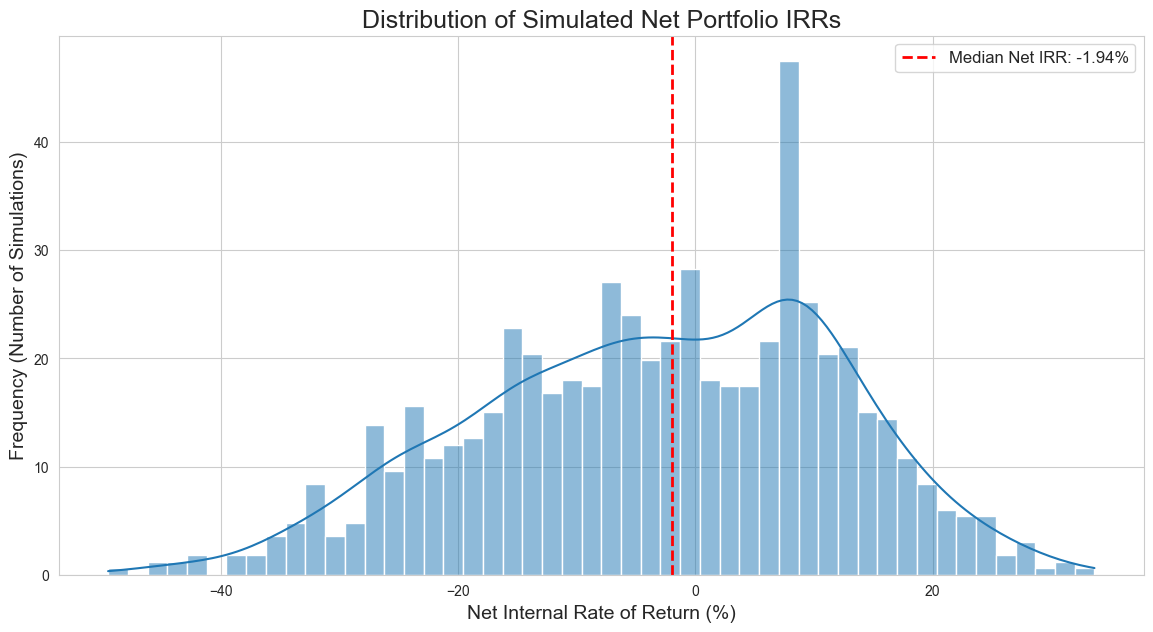

In [5]:
# ==============================================================================
# --- FINAL ANALYSIS & VISUALIZATION OF BASE CASE RESULTS ---
# ==============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if 'all_results' in locals() and all_results:
    
    # --- 1. Data Aggregation ---
    # This correctly converts the list of PortfolioResult objects into a DataFrame,
    # which is the standard and most efficient way to handle the data.
    df_results = pd.DataFrame([vars(res) for res in all_results])
    df_results.company_results.to_csv('check.csv')

    # --- 2. Model Diagnostics ---
    # This is an excellent diagnostic check. It verifies the frequency of specific edge cases,
    # which is crucial for understanding the model's stability and behavior.
    print("\n" + "="*80)
    print("--- MODEL DIAGNOSTICS ---")
    print("="*80)
    
    constrained_runs_pct = df_results['capital_constrained'].mean() * 100
    print(f"Percentage of portfolios that became capital constrained: {constrained_runs_pct:.2f}%")

    floored_irr_count = (df_results['net_irr'] <= -0.999).sum()
    total_runs = len(df_results)
    print(f"Percentage of Net IRRs floored to -100% (total loss): {(floored_irr_count/total_runs)*100:.2f}%")

    # --- 3. Descriptive Statistics & Risk Metrics ---
    # This section provides a comprehensive statistical summary and is a cornerstone of any
    # institutional-grade Monte Carlo analysis.
    print("\n\n" + "="*80)
    print("--- PORTFOLIO PERFORMANCE STATISTICS ---")
    print("="*80)
    
    # The use of describe() with custom percentiles is best practice.
    summary_stats = df_results[['gross_irr', 'net_irr', 'gross_multiple', 'net_multiple']].describe(percentiles=[.05, .25, .5, .75, .95])
    
    # The formatting logic below is excellent for presentation-ready tables.
    styler = summary_stats.style.format({
        'gross_irr': '{:,.2%}',
        'net_irr': '{:,.2%}',
        'gross_multiple': '{:,.2f}x',
        'net_multiple': '{:,.2f}x'
    }, na_rep="-").format("{:,.0f}", subset=pd.IndexSlice['count', :])

    print("\nIRR & Multiple Statistics:")
    display(styler)

    # The inclusion of VaR and CVaR demonstrates a sophisticated understanding of risk analysis.
    # These are key metrics that institutional investors look for.
    print("\nKey Risk Metrics (Based on Net IRR):")
    var_5_net = summary_stats.loc['5%', 'net_irr']
    cvar_5_net = df_results[df_results['net_irr'] <= var_5_net]['net_irr'].mean()
    print(f"  Value at Risk (VaR) at 5%: {var_5_net:.2%} (The worst-case outcome in 95% of scenarios)")
    print(f"  Conditional VaR (CVaR) at 5%: {cvar_5_net:.2%} (The average outcome of the worst 5% of scenarios)")

    # --- 4. Visualization ---
    # This is a perfect visualization for summarizing the results of a Monte Carlo simulation.
    print("\n\n" + "="*80)
    print("--- VISUALIZATION: NET IRR DISTRIBUTION ---")
    print("="*80)
    
    plt.figure(figsize=(14, 7))
    # Filtering out the extreme -100% IRR values is a smart choice for better visualization.
    viz_data = df_results[df_results['net_irr'] > -0.99]['net_irr'] * 100
    sns.histplot(viz_data, kde=True, stat='frequency', bins=50)
    
    plt.title('Distribution of Simulated Net Portfolio IRRs', fontsize=18)
    plt.xlabel('Net Internal Rate of Return (%)', fontsize=14)
    plt.ylabel('Frequency (Number of Simulations)', fontsize=14)
    
    median_net_irr = df_results['net_irr'].median() * 100
    plt.axvline(median_net_irr, color='red', linestyle='dashed', linewidth=2, label=f'Median Net IRR: {median_net_irr:.2f}%')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("The 'all_results' list not found or is empty. Please run the Base Case Simulation cell first.")

In [ ]:
all_results[4]

PortfolioResult(gross_irr=0.43286813505587096, net_irr=0.2390214747524323, gross_multiple=4.399267051496278, net_multiple=3.0789772525252523, capital_constrained=False, final_fund_life_years=10, num_extensions=0, average_check_size=987450.0, company_results=[CompanyResult(company_id=3, outcome='failed', failure_reason='probabilistic_failure', time_to_exit_months=12.0, total_invested=210000.0, exit_valuation=0, exit_ownership=0.15, exit_proceeds=0, multiple=0.0, history=[{'time': 5.66758396555323, 'event': 'Initial Investment', 'stage': 'Pre-Seed', 'premoney_valuation': 1190000.0, 'round_investment': 210000.0, 'round_dilution': 0.15, 'valuation': 1400000, 'ownership': 0.15}]), CompanyResult(company_id=4, outcome='failed', failure_reason='probabilistic_failure', time_to_exit_months=12.0, total_invested=165000.0, exit_valuation=0, exit_ownership=0.15, exit_proceeds=0, multiple=0.0, history=[{'time': 6.840019193286995, 'event': 'Initial Investment', 'stage': 'Pre-Seed', 'premoney_valuation